# Samples 3

Reran with wider range of parameter values

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import utils

In [2]:
from importlib import reload
reload(utils)

<module 'utils' from '/Users/Kelsey/Dropbox (uwamath)/autoray/results/utils.py'>

In [3]:
roi_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs', 'PTV']

samples = np.load('samples_6_11.npy', allow_pickle=True)
samples0 = [sample for sample in samples if sample[0] == 0]
samples1 = [sample for sample in samples if sample[0] == 1]
samples2 = [sample for sample in samples if sample[0] == 2]

par_dict0 = {roi: utils.roi_pars(samples0, roi)[0] for roi in roi_list}
par_dict1 = {roi: utils.roi_pars(samples1, roi)[0] for roi in roi_list}

goal_dict0 = {roi: [samples0[ii][4][roi][-1]['ResultValue'] for ii in range(len(samples0))] for roi in roi_list}
goal_dict1 = {roi: [samples1[ii][4][roi][-1]['ResultValue'] for ii in range(len(samples1))] for roi in roi_list}

# Dose Level Parameter Ranges

For the ROIs, I sampled between the 0-100% of the max dose range.

I wonder if we could look into the SVD to predict whether or not it is a success or not...

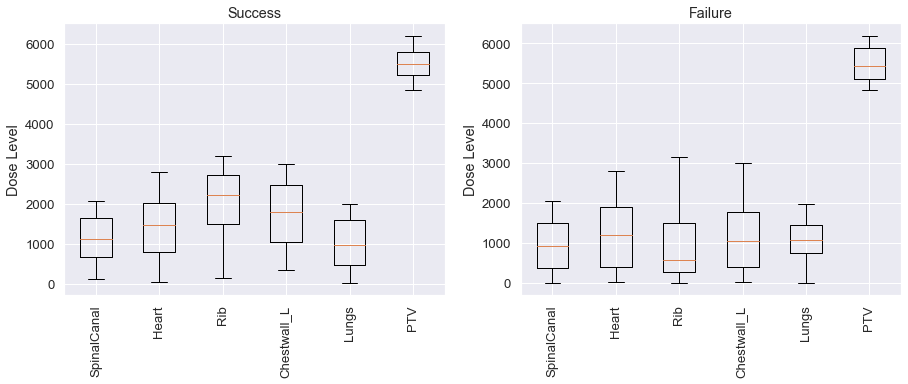

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

par_data0 = [par_dict0[roi] for roi in roi_list]
ax[0].boxplot(par_data0)
ax[0].set_xticklabels(labels=roi_list, rotation=90)
ax[0].set_ylabel('Dose Level')
ax[0].set_title('Success')

par_data1 = [par_dict1[roi] for roi in roi_list]
ax[1].boxplot(par_data1)
ax[1].set_xticklabels(labels=roi_list, rotation=90)
ax[1].set_ylabel('Dose Level')
ax[1].set_title('Failure');

# Goal Value Ranges

Here are the values that the resulting max doses achieved.

Wow, the PTV max is huge for some of the plans that failed once they're normalized, which is possibly on reason why they weren't achievable in the first place.

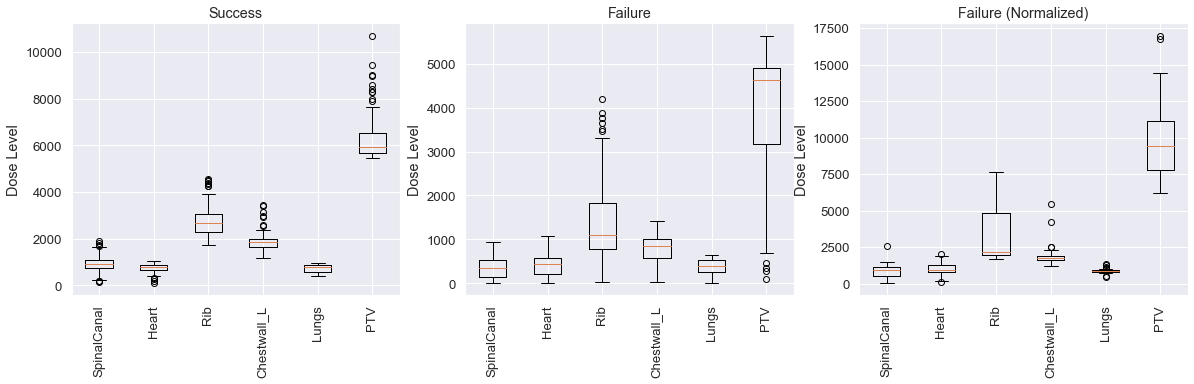

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

goal_data0 = [goal_dict0[roi] for roi in roi_list]
ax[0].boxplot(goal_data0)
ax[0].set_xticklabels(labels=roi_list, rotation=90)
ax[0].set_ylabel('Dose Level')
ax[0].set_title('Success')

goal_data1 = [goal_dict1[roi] for roi in roi_list]
ax[1].boxplot(goal_data1)
ax[1].set_xticklabels(labels=roi_list, rotation=90)
ax[1].set_ylabel('Dose Level')
ax[1].set_title('Failure')

D95 = [samples1[ii][2]['PTV']['D95'] for ii in range(len(samples1))]
goal_data2 = [4800*np.array(goal_data1[ii])/np.array(D95) for ii in range(6)]
ax[2].boxplot(goal_data2)
ax[2].set_xticklabels(labels=roi_list, rotation=90)
ax[2].set_ylabel('Dose Level')
ax[2].set_title('Failure (Normalized)');

# Correlation Between Parameters and Goals

Much different relationships than the smaller parameter set... here it's really mostly the objectives that influence their corresponding goals

We don't have the same teams of competing goals anymore: 
* SpinalCanal, Rib, PTV, Chestwall_L
* Lungs, Heart

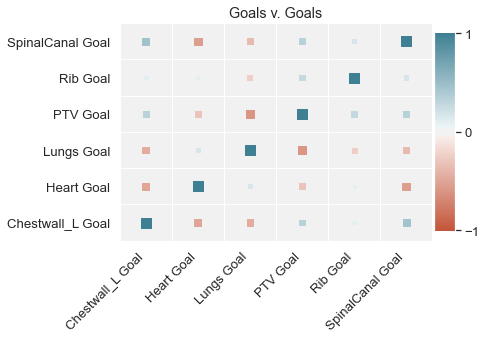

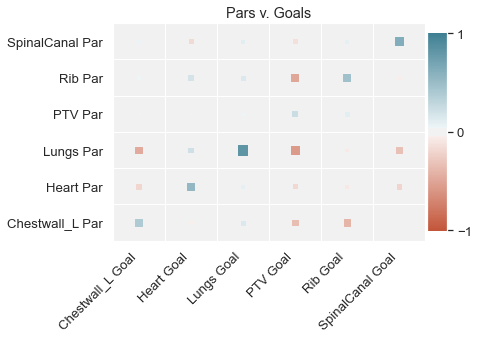

In [70]:
res_dict = {}
par_labels = [f'{roi} Par' for roi in roi_list]
goal_labels = [f'{roi} Goal' for roi in roi_list]
for roi in roi_list:
    res_dict[f'{roi} Par'] = par_dict0[roi]
    res_dict[f'{roi} Goal'] = goal_dict0[roi]
utils.corrplot(res_dict, 'Goals v. Goals', x_labels=goal_labels, y_labels=goal_labels)
plt.figure()
utils.corrplot(res_dict, 'Pars v. Goals', x_labels=par_labels, y_labels=goal_labels)

# Plotting Goals v. Pars

Can we see the relationships here? Are they different from before?

What if we looked at the two most important values...

* SpinalCanal: SpinalCanal (0.63), Lungs (-0.33)
* Heart: Heart (0.54), Lungs (0.22)
* Rib: Rib (0.47), Chestwall_L (-0.4)
* Chestwall_L: Lungs (-0.46), Chestwall_L (0.43)
* Lungs: Lungs (0.83), Rib (0.15)
* PTV: Rib (-0.48), Lungs (-0.56), PTV (0.24)

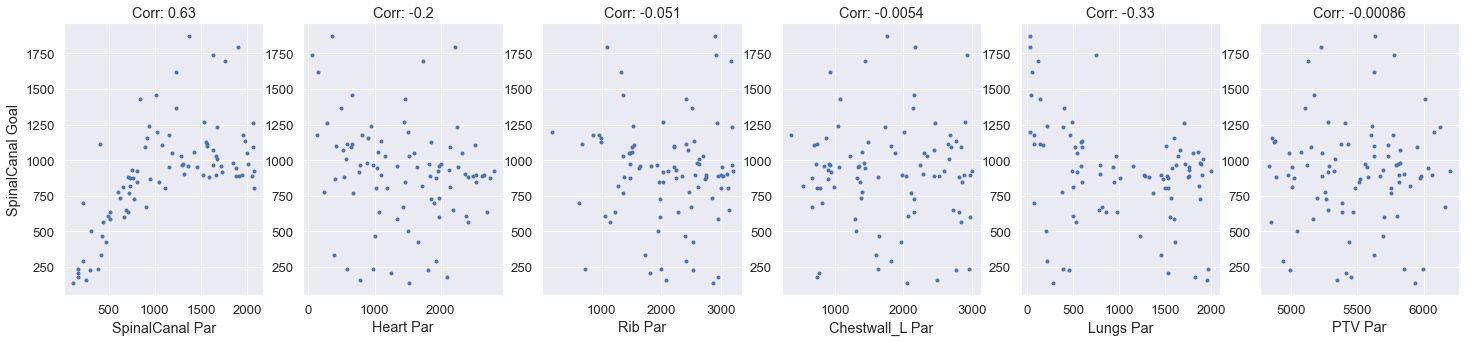

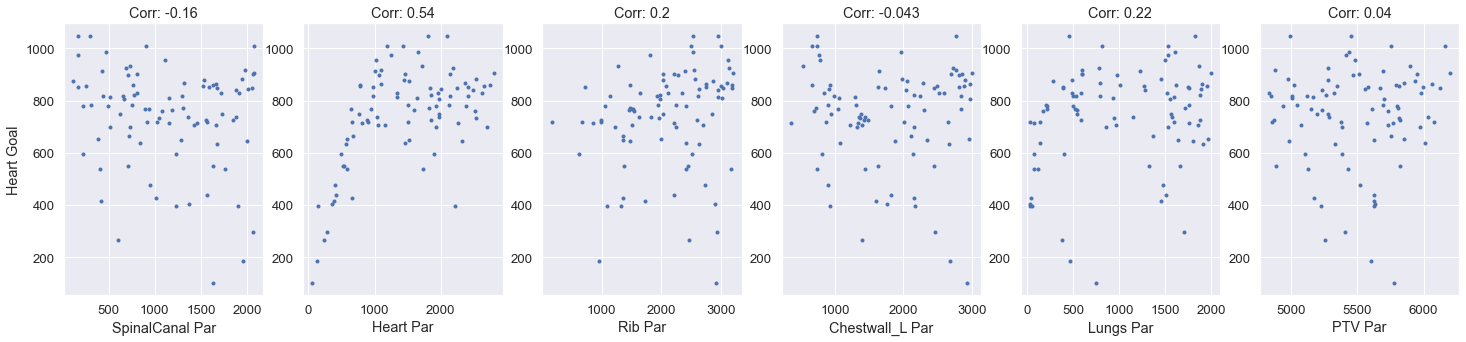

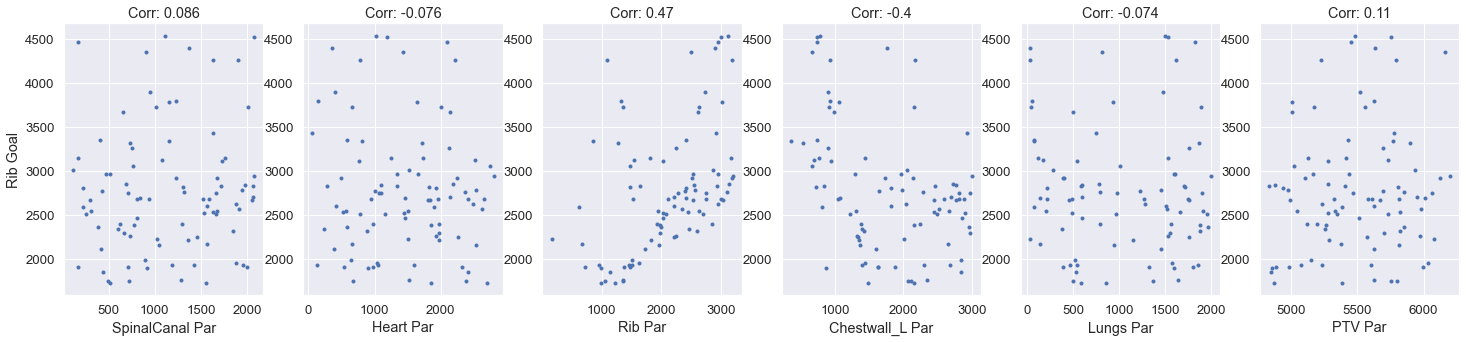

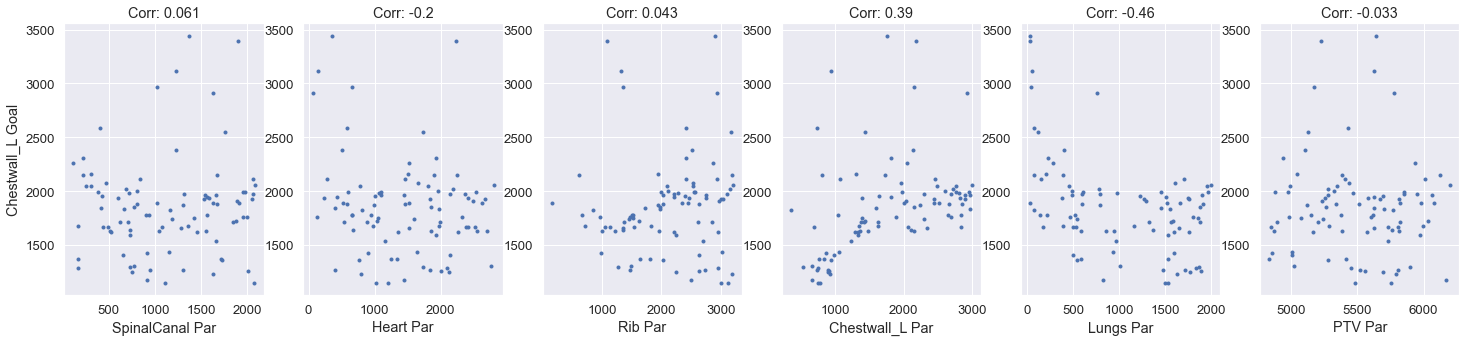

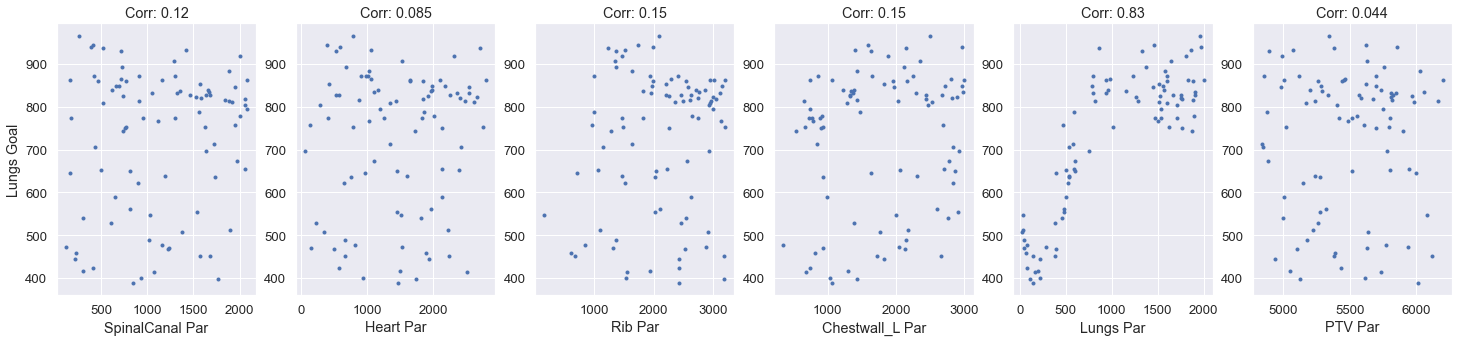

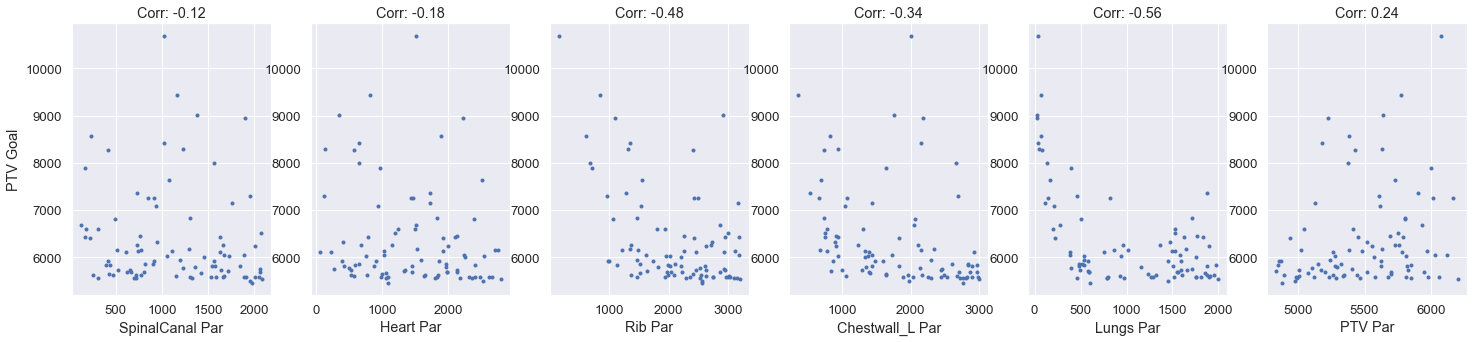

In [73]:
for ii in range(len(roi_list)):
    fig, ax = plt.subplots(1, 6, figsize=(25, 5))
    for jj in range(len(roi_list)):
        x = par_dict0[roi_list[jj]]
        y = goal_dict0[roi_list[ii]]
        ax[jj].plot(x, y, '.')
        ax[jj].set_xlabel(f'{roi_list[jj]} Par')
        ax[jj].set_title(f'Corr: {np.corrcoef(x, y)[0, 1]:.2}')
    ax[0].set_ylabel(f'{roi_list[ii]} Goal')

Pars: 1, Train: 0.7802, Test: 0.3261
Pars: 2, Train: 0.7081, Test: 0.6392
Pars: 3, Train: 0.7081, Test: 0.6392
Pars: 4, Train: 0.7081, Test: 0.6392
Pars: 5, Train: 0.7081, Test: 0.6392
Pars: 6, Train: 0.7081, Test: 0.6392


Text(0, 0.5, 'Score')

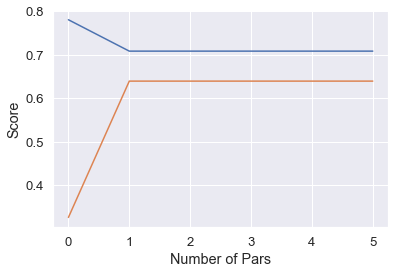

In [277]:
# Predict PTV scores using increasingly more parameters

# Lungs -0.56
# Rib -0.48
# Chestwall_L -0.34
# PTV 0.24
# Heart 0.18
# SpinalCanal 0.12

train_error = []
test_error = []
my_list = ['Lungs', 'Rib', 'Chestwall_L', 'PTV', 'Heart', 'SpinalCanal']
n = int(np.ceil(0.8*88))
for ii in range(len(my_list)):
    # Build model
    x_data = np.zeros((ii+1, 88))
    for jj in range(ii+1):
        x_data[jj] = par_dict0[my_list[jj]]
    y_data = np.array(score_dict['PTV'])
    gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0)\
              .fit(x_data[:, :n].T, (y_data[:n] - np.mean(y_data[:n]))/np.std(y_data[:n]))

    # Make predictions
    y_est = gpr.predict(x_data[:, :n].T)
    y_est = y_est*np.std(y_data[:n]) + np.mean(y_data[:n])
    train_error.append(np.linalg.norm(y_est - y_data[:n]))
    y_est = gpr.predict(x_data[:, n:].T)
    y_est = y_est*np.std(y_data[:n]) + np.mean(y_data[:n])
    test_error.append(np.linalg.norm(y_est - y_data[n:]))    
    
    # Results
    print(f'Pars: {ii+1}, Train: {train_error[ii]:.4}, Test: {test_error[ii]:.4}')

plt.plot(train_error)
plt.plot(test_error)
plt.xlabel('Number of Pars')
plt.ylabel('Score')

# Predict ROI Scores With Top Two Parameters

In [263]:
use_dict = {
    'SpinalCanal': ['SpinalCanal', 'Lungs'],
    'Heart': ['Heart', 'Lungs'],
    'Rib': ['Rib', 'Chestwall_L'],
    'Chestwall_L': ['Lungs', 'Chestwall_L'],
    'Lungs': ['Lungs', 'Rib'],
    'PTV': ['Lungs', 'Rib']
}

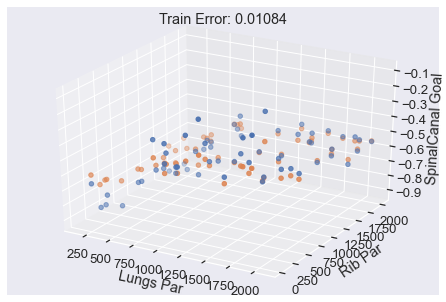

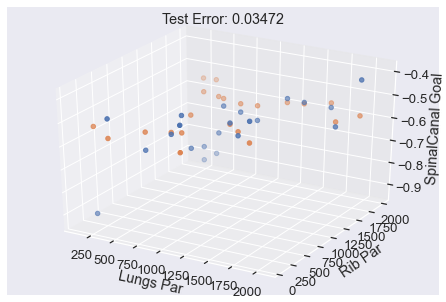

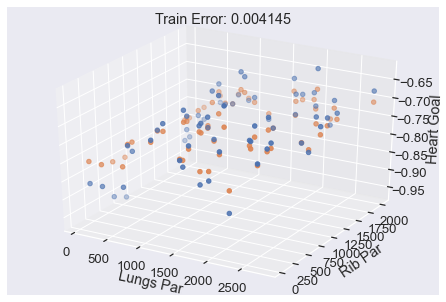

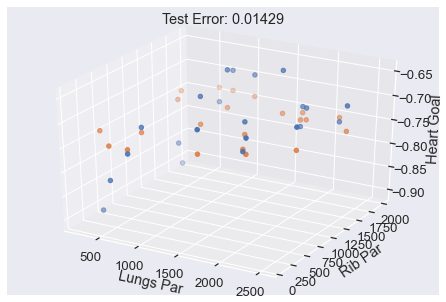

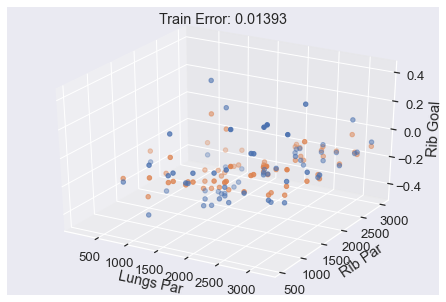

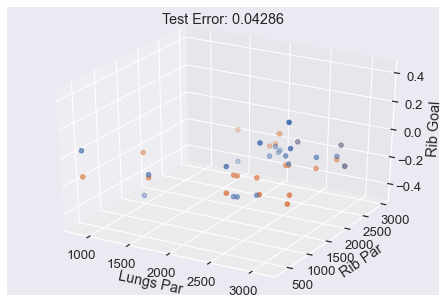

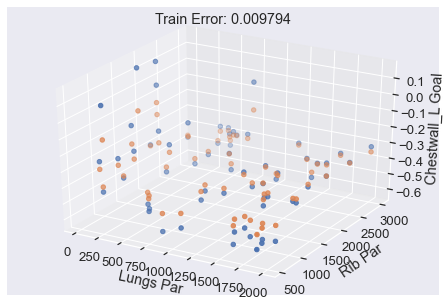

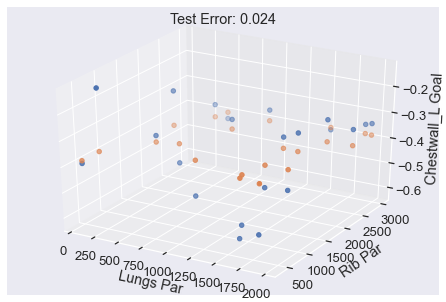

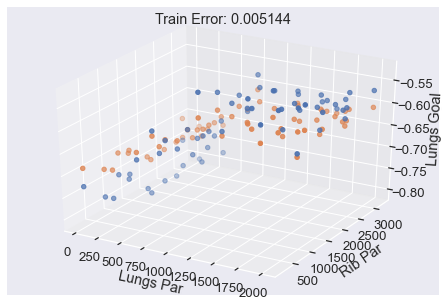

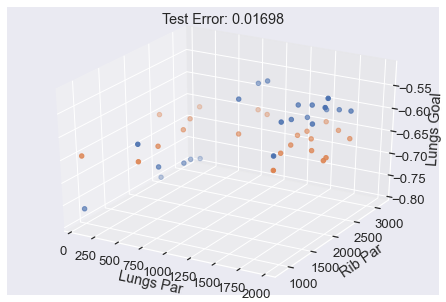

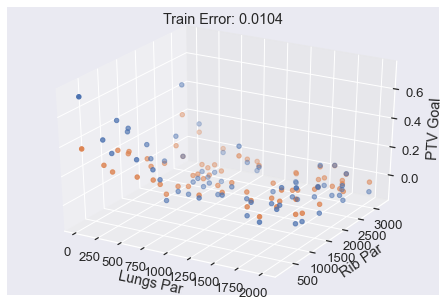

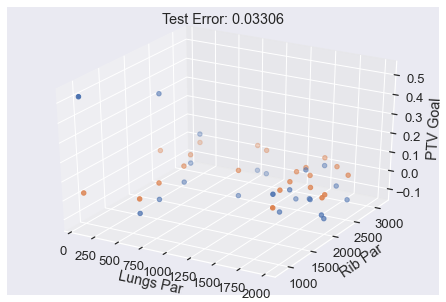

In [303]:
# Some seem overfit

n = 66
for ii in range(len(roi_list)):
    # Build model
    x_data = np.zeros((2, 88))
    for jj in range(2):
        x_data[jj] = par_dict0[use_dict[roi_list[ii]][jj]]
    y_data = np.array(score_dict[roi_list[ii]])
    gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0)\
              .fit(x_data[:, :n].T, (y_data[:n] - np.mean(y_data[:n]))/np.std(y_data[:n]))

    # Make predictions
    y_train = gpr.predict(x_data[:, :n].T)
    y_train = y_train*np.std(y_data[:n]) + np.mean(y_data[:n])
    train_error = (np.linalg.norm(y_train - y_data[:n]))
    y_test = gpr.predict(x_data[:, n:].T)
    y_test = y_test*np.std(y_data[:n]) + np.mean(y_data[:n])
    test_error = (np.linalg.norm(y_test - y_data[n:]))    
    
    # Results
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_data[0, :n], x_data[1, :n], y_data[:n])
    ax.scatter(x_data[0, :n], x_data[1, :n], y_train)
    ax.set_xlabel(f'{use_dict[roi][0]} Par')
    ax.set_ylabel(f'{use_dict[roi][1]} Par')
    ax.set_zlabel(f'{roi_list[ii]} Goal')
    ax.set_title(f'Train Error: {train_error/n:.4}')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_data[0, n:], x_data[1, n:], y_data[n:])
    ax.scatter(x_data[0, n:], x_data[1, n:], y_test)
    ax.set_xlabel(f'{use_dict[roi][0]} Par')
    ax.set_ylabel(f'{use_dict[roi][1]} Par')
    ax.set_zlabel(f'{roi_list[ii]} Goal')
    ax.set_title(f'Test Error: {test_error/(88-n):.4}')

Question: Better to predict ROI score first, then total score, or better to predict score based on some parameters???

# PCA

Not lower dimensional like the other one was

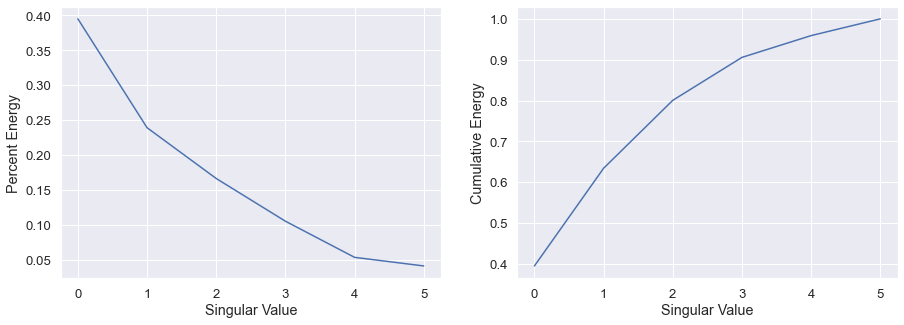

In [75]:
# How many dimensions do we have in the goals?
goal_mat = np.array([goal_dict0[roi] for roi in roi_list])
goal_mat -= np.outer(np.mean(goal_mat, axis=1), np.ones(goal_mat.shape[1]))
[U, S, Vh] = np.linalg.svd(goal_mat)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(S/sum(S))
ax[0].set_xlabel('Singular Value')
ax[0].set_ylabel('Percent Energy');

ax[1].plot(np.cumsum(S)/sum(S))
ax[1].set_xlabel('Singular Value')
ax[1].set_ylabel('Cumulative Energy');

# Didn't divide by standard deviation, since all are in the same unit cGy

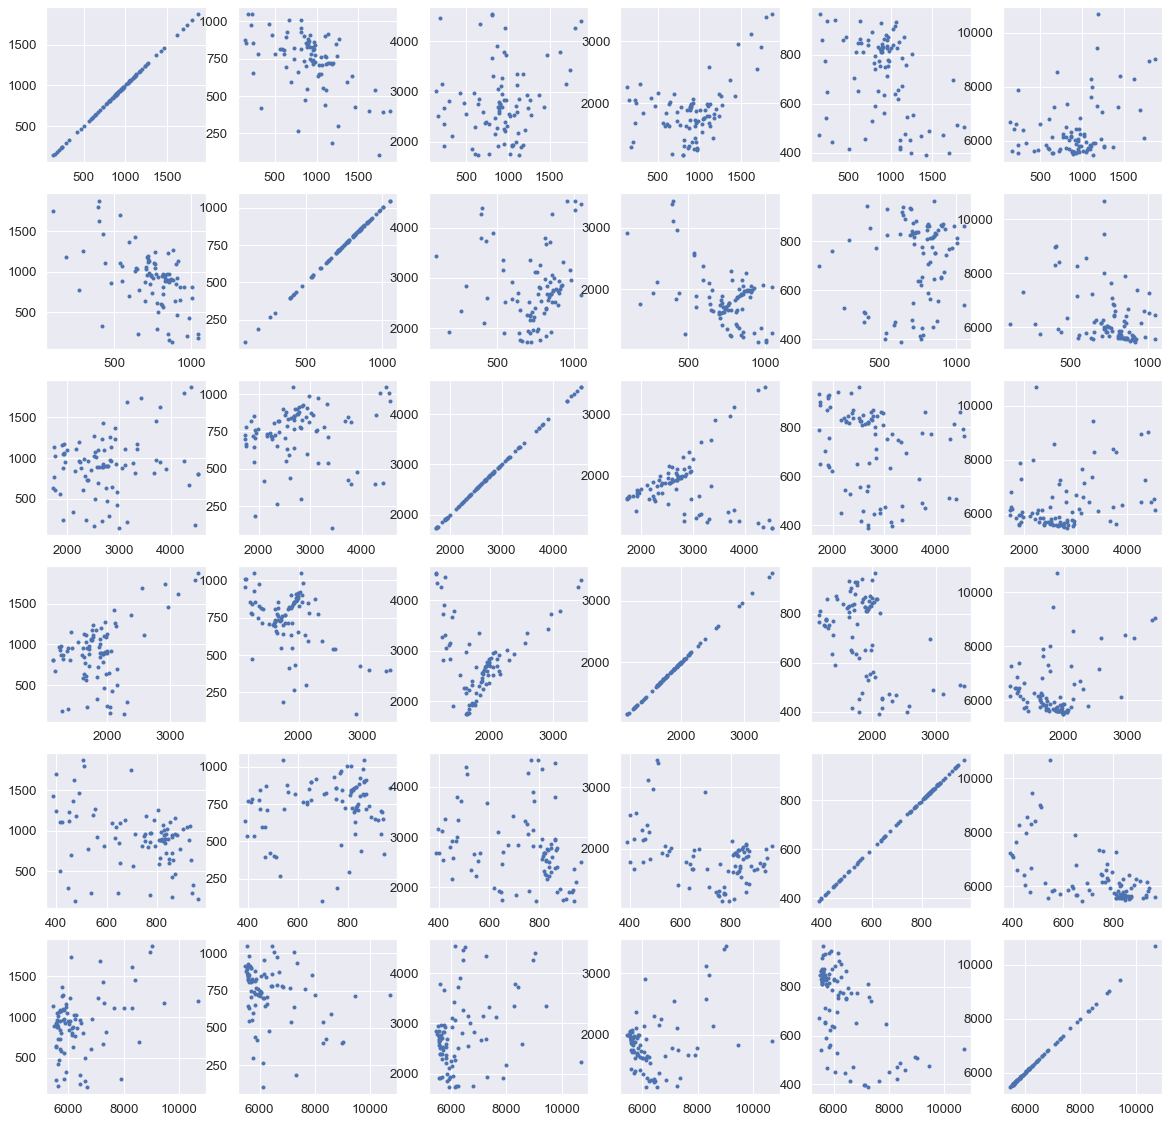

In [76]:
# Relationships between goal values
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
for ii in range(len(roi_list)):
    for jj in range(len(roi_list)):
        ax[ii, jj].plot(goal_dict0[roi_list[ii]], goal_dict0[roi_list[jj]], '.')

In [ ]:
# Maybe we could do PCA with each organ individually to see how many parameters each of them need?
# Or we could go in order of correlation and see errors and how many we can add before it gets worse?

In [ ]:
# Look into predicting score (use percentage criteria as per minsun email)
# Start running plans for new patient
# Look into predicting each organ using variety of parameters
# Look into predicting score using variety of parameters, what are the correlations???

# Looking at the Plan Scores

In [121]:
max_dict = {}
for roi in roi_list:
    max_dict[roi] = samples[0][4][roi][-1]['DoseValue']

In [122]:
score_dict = {}
for roi in roi_list:
    score_dict[roi] = [(goal - max_dict[roi])/max_dict[roi] for goal in goal_dict0[roi]]

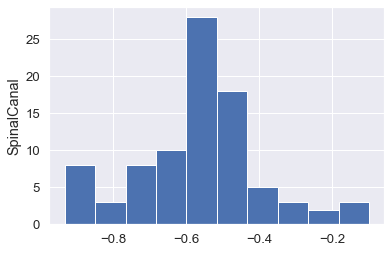

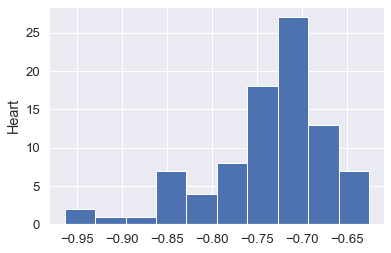

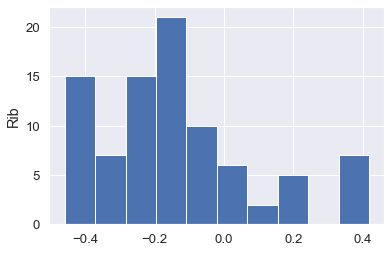

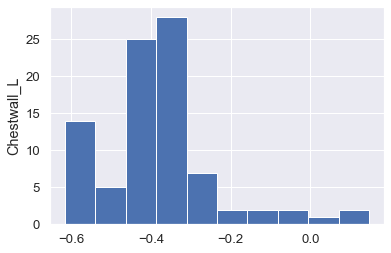

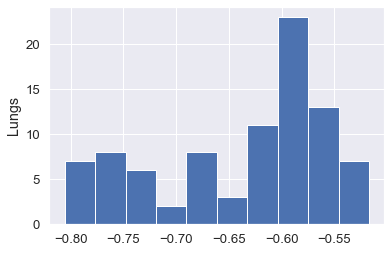

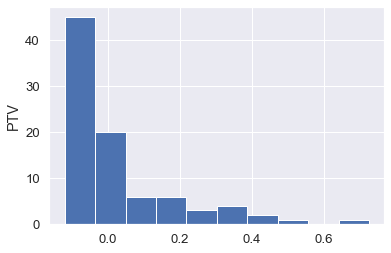

In [125]:
for roi in roi_list:
    plt.figure()
    plt.hist(score_dict[roi])
    plt.ylabel(roi)

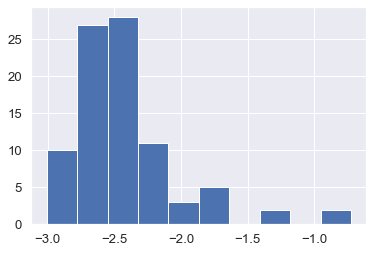

In [129]:
score_list = np.zeros(88)
for roi in roi_list:
    score_list += score_dict[roi]
plt.hist(score_list);

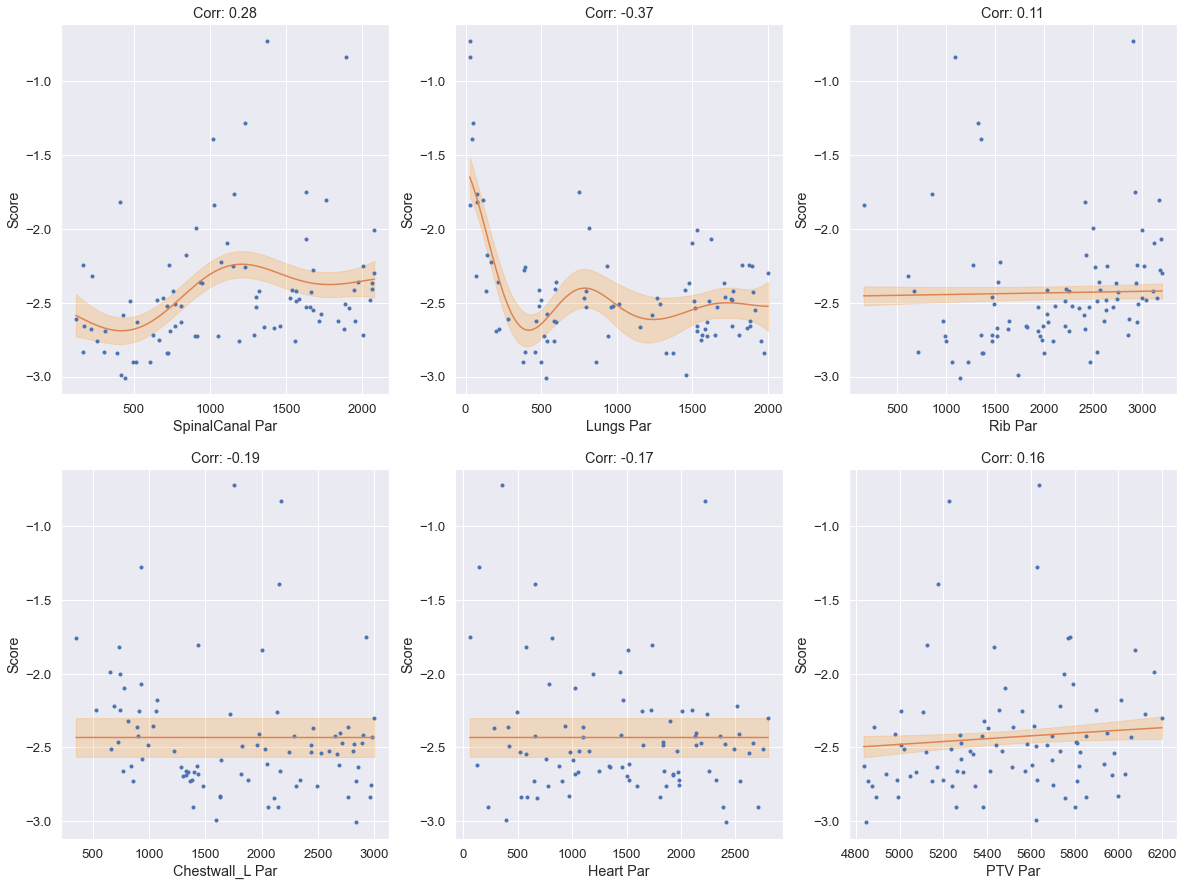

In [178]:
# Plot results
a_vals = [1e0, 1e1, 1e0, 1e1, 1e0, 1e0]
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for ii in range(len(roi_list)):
    # Build model
    x_data = np.array(par_dict0[roi_list[ii]])
    y_data = score_list
    gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=a_vals[ii])\
              .fit(x_data.reshape(-1, 1), (y_data - np.mean(y_data))/np.std(y_data))

    # Make predictions
    x_est = np.linspace(min(x_data), max(x_data), 100)
    y_est, std = gpr.predict(x_est.reshape(-1, 1), return_std=True)
    y_est = y_est*np.std(y_data) + np.mean(y_data)
    std *= np.std(y_data)
    
    # Plot results
    ax[np.mod(ii, 2), np.mod(ii, 3)].plot(x_data, y_data, '.')
    ax[np.mod(ii, 2), np.mod(ii, 3)].plot(x_est, y_est)
    ax[np.mod(ii, 2), np.mod(ii, 3)].fill_between(x_est, y_est - std,
                                                  y_est + std, color='darkorange', alpha=0.2)
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_xlabel(f'{roi_list[ii]} Par')
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_ylabel('Score')
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_title(f'Corr: {np.corrcoef(x_data, y_data)[0, 1]:.2}')

# Looking at best score in the samples

In [309]:
min(score_list)

-3.007061099371542

In [308]:
idx = np.argmin(score_list)
for roi in roi_list:
    print(f'{roi} Par: {par_dict0[roi][idx]}, Score: {score_dict[roi][idx]}')

SpinalCanal Par: 438, Score: -0.7287866567530725
Heart Par: 2415, Score: -0.7083582065434605
Rib Par: 1140, Score: -0.42250776348433994
Chestwall_L Par: 2838, Score: -0.44262608381818996
Lungs Par: 534, Score: -0.6474884119579628
PTV Par: 4848, Score: -0.05729397681451613
